In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    auc
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
use_cols = [
    "step", "type", "amount",
    "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest",
    "isFraud"
]

df = pd.read_csv(
    "Fraud.csv",
    usecols=use_cols,
    low_memory=True
)

print("Original shape:", df.shape)


Original shape: (6362620, 8)


In [3]:
df = df.sample(n=1_000_000, random_state=42)
print("Sampled shape:", df.shape)


Sampled shape: (1000000, 8)


In [4]:
df["orig_balance_diff"] = df["oldbalanceOrg"] - df["newbalanceOrig"]
df["dest_balance_diff"] = df["newbalanceDest"] - df["oldbalanceDest"]

df["orig_empty"] = (df["oldbalanceOrg"] == 0).astype("int8")
df["dest_empty"] = (df["oldbalanceDest"] == 0).astype("int8")

df["amount_log"] = np.log1p(df["amount"])
df["is_night"] = (df["step"] % 24 < 6).astype("int8")


In [5]:
df["type"] = df["type"].astype("category").cat.codes

df.replace([np.inf, -np.inf], 0, inplace=True)
df.fillna(0, inplace=True)


In [6]:
X = df.drop(columns=["isFraud"])
y = df["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [7]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

lr.fit(X_train, y_train)

lr_pred = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, lr_pred))


Logistic Regression ROC-AUC: 0.9664718952478839


In [8]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_leaf=100,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

rf_pred = rf.predict_proba(X_test)[:, 1]

print("Random Forest ROC-AUC:", roc_auc_score(y_test, rf_pred))


Random Forest ROC-AUC: 0.9995372802721926


In [9]:
precision, recall, _ = precision_recall_curve(y_test, rf_pred)
print("PR-AUC:", auc(recall, precision))


PR-AUC: 0.9034903886329728


In [10]:
y_pred = (rf_pred > 0.9).astype(int)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199747
           1       0.98      0.75      0.85       253

    accuracy                           1.00    200000
   macro avg       0.99      0.88      0.93    200000
weighted avg       1.00      1.00      1.00    200000



In [11]:
importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

importance.head(10)


,feature,importance
7,orig_balance_diff,0.331488
3,oldbalanceOrg,0.147387
4,newbalanceOrig,0.124897
2,amount,0.077486
11,amount_log,0.069748
1,type,0.061759
8,dest_balance_diff,0.047182
0,step,0.045955
9,orig_empty,0.043829
6,newbalanceDest,0.018984


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


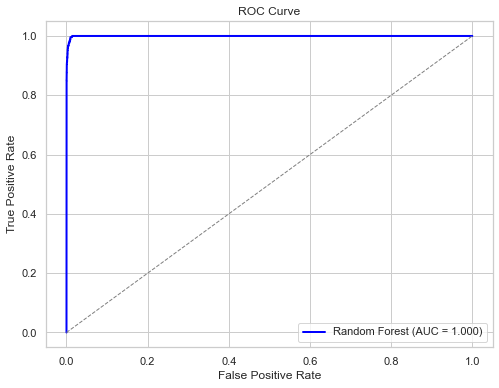

In [13]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, rf_pred)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf_pred):.3f})')
plt.plot([0,1], [0,1], color='grey', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


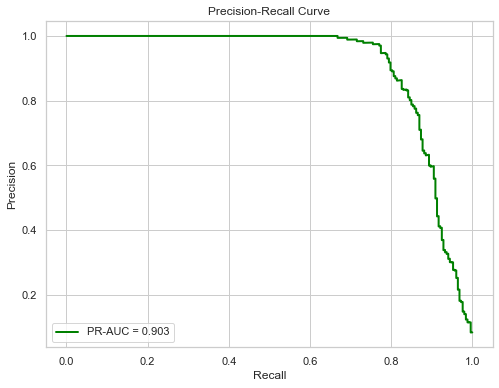

In [14]:
precision, recall, thresholds = precision_recall_curve(y_test, rf_pred)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR-AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


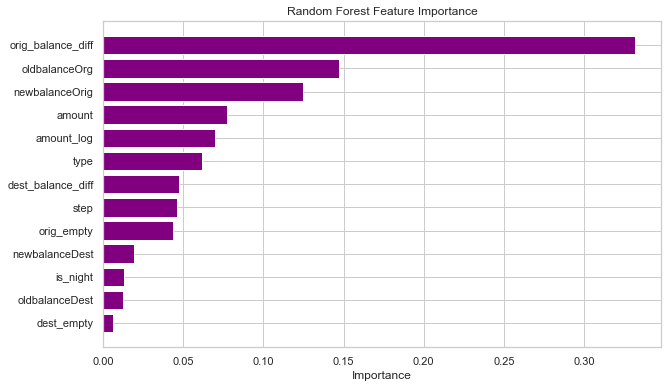

In [15]:
importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=True)

plt.figure(figsize=(10,6))
plt.barh(importance['feature'], importance['importance'], color='purple')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.show()


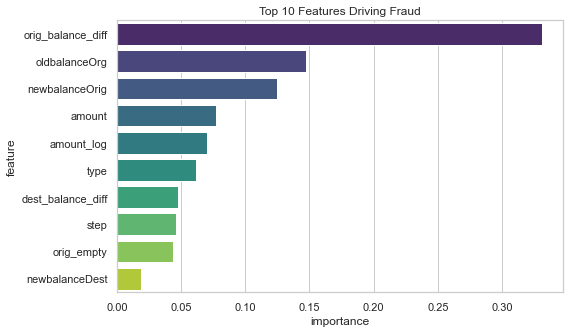

In [16]:
top_features = importance.sort_values("importance", ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Top 10 Features Driving Fraud')
plt.show()
